##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a
caption such as "a surfer riding on a wave".

<table style="text-align: center;">
<tr>
  <td>
   <img src="https://tensorflow.org/images/surf.jpg"/>
  </td>
</tr>
<tr>
  <th>A man surfing, from <a href=https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg>wikimedia</a></th>
</tr>
</table>

The model architecture used here is inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), but has been updated to use a 2-layer Transformer-decoder. To get the most out of this tutorial you should have some experience with [text generation](https://www.tensorflow.org/text/tutorials/text_generation),  [seq2seq models & attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention), or [transformers](https://www.tensorflow.org/text/tutorials/transformer).

The model architecture built in this tutorial is shown below. Features are extracted from the image, and passed to the cross-attention layers of the Transformer-decoder.

<table>
<tr>
  <th>The model architecture</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"/>
  </td>
</tr>
</table>

The transformer decoder is mainly built from attention layers. It uses self-attention to process the sequence being generated, and it uses cross-attention to attend to the image.

By inspecting the attention weights of the cross attention layers you will see what parts of the image the model is looking at as it generates words.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

This notebook is an end-to-end example. When you run the notebook, it downloads a dataset, extracts and caches the image features, and trains a decoder model. It then uses the model to generate captions on new images.

## Setup

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 -y

In [ ]:
!pip uninstall -y tensorflow estimator keras

In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

In [ ]:
!pip install einops

This tutorial uses lots of imports, mostly for loading the dataset(s).

In [ ]:
#@title
import os
import re
import json
import math
import time
import tqdm
import einops
import random
import string
import hashlib
import pathlib
import requests
import itertools
import collections
import dataclasses
import urllib.request
import concurrent.futures

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import gensim.downloader as api
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import nltk.translate.bleu_score as bleu

from PIL import Image

## [Optional] Data handling

This section downloads a captions dataset and prepares it for training. It tokenizes the input text, and caches the results of running all the images through a pretrained feature-extractor model. It's not critical to understand everything in this section.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


## Flickr30k-images-ecemod

In [ ]:
# Download image files
image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
os.remove(image_zip)

In [ ]:
# Download captions file
captions_file = tf.keras.utils.get_file('captions_new.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                           extract=False)

# Download train files list
train_files_list = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                           extract=False)

# Download test files list
test_files_list = tf.keras.utils.get_file('test_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                           extract=False)

In [518]:
path="."
IMAGE_DIR="image_dir"
path = pathlib.Path(path)
   
captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)
   
cap_dict = collections.defaultdict(list)
for fname, cap in captions:
  cap_dict[fname].append(cap)
   
train_files = (path/train_files_list).read_text().splitlines()
train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]
   
test_files = (path/test_files_list).read_text().splitlines()
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]
   
train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

In [519]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [520]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'image_dir/_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)


### Image feature extractor

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


In [521]:
IMAGE_SHAPE=(224, 224, 3)

# mobilenet = tf.keras.applications.MobileNetV3Small(
#     input_shape=IMAGE_SHAPE,
#     include_top=False,
#     include_preprocessing=True)
# mobilenet.trainable=False

efficientnet = tf.keras.applications.EfficientNetB0(
    input_shape=IMAGE_SHAPE,
    include_top=False,)
efficientnet.trainable=False

Here's a function to load an image and resize it for the model:

In [522]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

The model returns a feature map for each image in the input batch:

In [523]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(efficientnet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 1280)


### Setup the text tokenizer/vectorizer

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [524]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

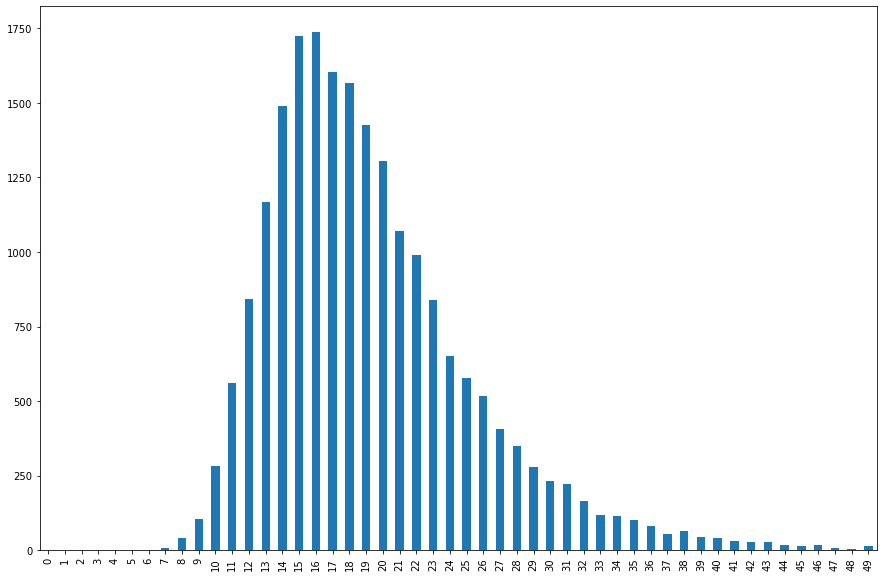

Number of captions before limiting length range: 21000
Number of captions after limiting length range: 18829


In [525]:
def get_caption_length(caption):
    return len(caption[0].split())
  
lengths = np.zeros(100)
for caption_tuple in train_captions:
    lengths[get_caption_length(caption_tuple[1])] += 1

df = pd.DataFrame(lengths[:50])
df.plot(kind='bar', stacked=False, legend=False, figsize=(15, 10))
plt.show()

MIN_LENGTH = 11
MAX_LENGTH = 28

print(f"Number of captions before limiting length range: {len(train_captions)}")
train_captions = [caption_tuple for caption_tuple in train_captions if get_caption_length(caption_tuple[1]) >= MIN_LENGTH and get_caption_length(caption_tuple[1]) <= MAX_LENGTH]
print(f"Number of captions after limiting length range: {len(train_captions)}")

In [463]:
vocabulary_size = 7000

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)

In [464]:
# Learn the vocabulary from the caption data
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [465]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'and', 'man']

In [466]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 755, 5, 2, 63, 4], [3, 2, 2866, 34, 4]]>

In [467]:
# Create mappings for words to indices and indices to words
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [468]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [469]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Prepare the datasets

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs. 

This function will replicate the image so there are 1:1 images to captions:

In [470]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [471]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [472]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [473]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [474]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [475]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### [Optional] Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`: 

In [476]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [477]:
# save_dataset(train_raw, 'train_cache', efficientnet, tokenizer)
# save_dataset(test_raw, 'test_cache', efficientnet, tokenizer)

 </section>


## Data ready for training

After those preprocessing steps, here are the datasets:

In [478]:
# train_ds = load_dataset('train_cache')
# test_ds = load_dataset('test_cache')

In [479]:
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [480]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 224, 224, 3)
(32, 35)
(32, 35)


The input tokens and the labels are the same, just shifted by 1 step:

In [481]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3    2  348  640   16 6591   61    2  333  265    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
[   2  348  640   16 6591   61    2  333  265    4    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


## A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs. 

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [482]:
embed = api.load('glove-wiki-gigaword-200')

In [483]:
EMBEDDING_DIM = embed[0].shape[0]

# create embedding matrix for words in our vocabulary
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for i, word in enumerate(tokenizer.get_vocabulary()):
    #check if word is in embed dictionary
    if word in embed:
        embedding_vector = embed[word]
        embedding_matrix[i] = embedding_vector
    else :
        embedding_matrix[i] = np.zeros(EMBEDDING_DIM)

In [484]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    # self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=EMBEDDING_DIM)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        # output_dim=depth,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        trainable=False,
        mask_zero=True)

    self.dense = tf.keras.layers.Dense(units=depth)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    # return self.add([seq,x])
    return self.dense(seq + x)

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [485]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [486]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [487]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [488]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`, 
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well. 

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [489]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this
    # An Add layer doesn't work because of the different shapes
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses
    return x + self.bias

The smart initialization will significantly reduce the initial loss:

In [490]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

3282it [02:12, 24.74it/s]


Uniform entropy: 8.85
Marginal entropy: 5.53


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [491]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=100, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [492]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [493]:
model = Captioner(tokenizer, feature_extractor=efficientnet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [494]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [495]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(MAX_LENGTH):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [496]:
@Captioner.add_method
def beam_search(self, image, beam_width=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])
  
  # Initialize the beams with the initial token
  beams = [{'tokens': initial, 'log_probs': 0}]

  # Repeat until all beams have reached the end token or the maximum number of steps
  for n in range(MAX_LENGTH):
    new_beams = []
    for beam in beams:
      preds = self((img_features, beam['tokens'])).numpy()  # (batch, sequence, vocab)
      preds = preds[:,-1, :]  # (batch, vocab)
      next_word_probs = tf.math.softmax(preds)
      next_word_probs = next_word_probs.numpy()[0]  # remove the batch dimension
      
      # Get the top 'beam_width' words and their corresponding log probabilities
      next_word_probs, next_word_indices = tf.math.top_k(next_word_probs, k=beam_width)
      
      for word_log_prob, word_index in zip(next_word_probs.numpy(), next_word_indices.numpy()):
        new_beam = {
            'tokens': tf.concat([beam['tokens'], [[word_index]]], axis=1),
            'log_probs': beam['log_probs'] + np.log(word_log_prob)
        }
        new_beams.append(new_beam)

    beams = sorted(new_beams, key=lambda x: x['log_probs'], reverse=True)[:beam_width]

    # Exit loop if the end token is found
    if any(beam['tokens'][0,-1] == self.word_to_index('[END]') for beam in beams):
      break

  # Return the sentence with the highest log probability
  best_beam = max(beams, key=lambda x: x['log_probs'])
  words = index_to_word(best_beam['tokens'][0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [497]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a a a a a a a a a a a a a a a a a a a a a a a a a a a
girl a a in a a a a a a the
a down a on a railing little a a a preparing a playing in of


The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`). 

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [498]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [499]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()

It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [500]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a a a a a a a a a a a a a a a a a a a a a a a a a a a
a a a a a a a a man a a a
with a a the



Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [501]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

Configure and execute the training.

In [502]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`. 

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [503]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100


2023-02-10 16:57:04.509498: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incaptioner_9/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - ETA: 0s - loss: 5.2583 - masked_acc: 0.1862

a man in a man in a man in a man in a man in a man in a man in a man in a man in
a men in the his in the of a pink is
a rides hair standing hanging on a girl forest

100/100 [==============================] - 42s 244ms/step - loss: 5.2583 - masked_acc: 0.1862 - val_loss: 5.0164 - val_masked_acc: 0.2207
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.8964 - masked_acc: 0.2300

a man in a man in a man in a man in a
a man is in a woman with a white shirt is in a a the to a blue and a
snowy and building out tshirt at purple

100/100 [==============================] - 18s 181ms/step - loss: 4.8964 - masked_acc: 0.2300 - val_loss: 4.7339 - val_masked_acc: 0.2513
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.7387 - masked_acc: 0.2510

a man in a man in a white shirt is in a white shirt is in a blue shirt and a blue shirt and a white shirt
a man is in a bo

2023-02-10 16:58:53.922622: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


100/100 [==============================] - ETA: 0s - loss: 4.4364 - masked_acc: 0.2838

a man in a blue shirt is holding a blue shirt is holding a blue shirt is holding a
a woman in a blue shirt is on a green shirt is water
a blue white outfit a boy is while a classroom

100/100 [==============================] - 18s 183ms/step - loss: 4.4364 - masked_acc: 0.2838 - val_loss: 4.3683 - val_masked_acc: 0.2916
Epoch 7/100
100/100 [==============================] - ETA: 0s - loss: 4.3810 - masked_acc: 0.2859

a man in a blue shirt is playing in a blue shirt is playing in the water
a man in a blue shirt is playing in the water
a man is time bus

100/100 [==============================] - 16s 161ms/step - loss: 4.3810 - masked_acc: 0.2859 - val_loss: 4.3224 - val_masked_acc: 0.2841
Epoch 8/100
100/100 [==============================] - ETA: 0s - loss: 4.2709 - masked_acc: 0.2943

a man in a blue shirt is playing a blue shirt is playing a blue shirt is playing a water
a young boy is riding a r

Plot the loss and accuracy over the training run:

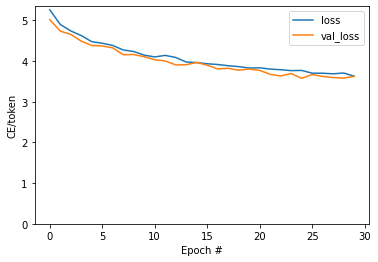

In [504]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

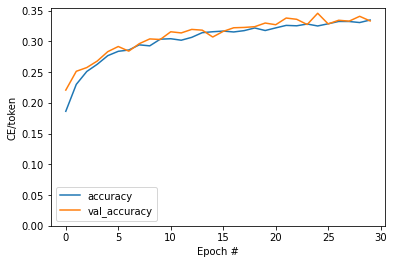

In [505]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [506]:
result = model.simple_gen(image, temperature=0.0)
result

'a man in a blue shirt is jumping into the water'

Split the output back into tokens:

In [507]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [508]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 12, 49]), TensorShape([1, 2, 12, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [509]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [510]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994], dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [511]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

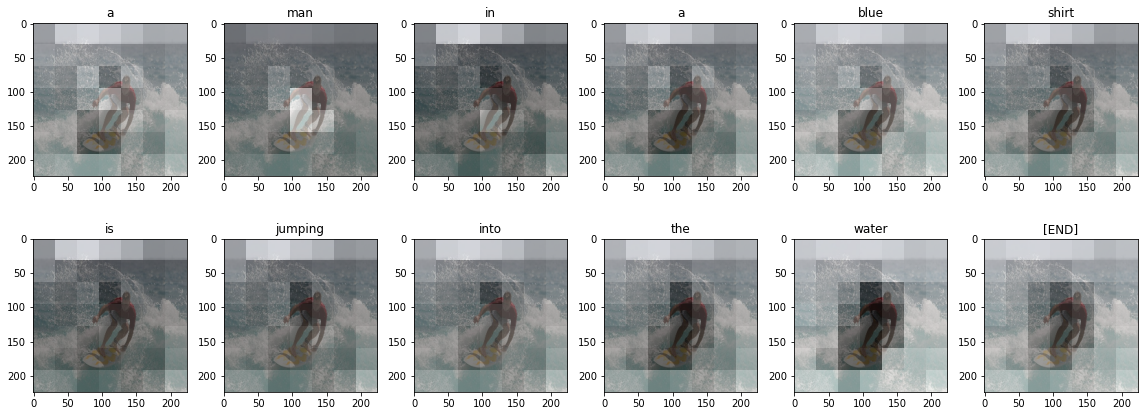

In [512]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [513]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

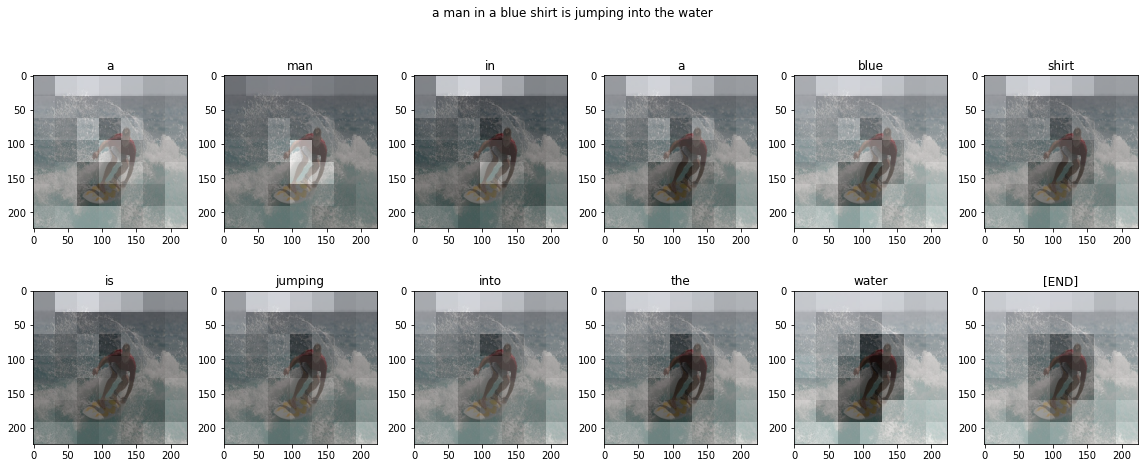

In [514]:
run_and_show_attention(model, image)

## BLEU score

### BLEU score evaluation functions

In [515]:
def calculate_bleu_single(references, hypothesis):
    references = [r.split() for r in references]
    references = [r[:-1] if r[-1] == "." else r for r in references]
    hypothesis = hypothesis.split()
    return bleu.sentence_bleu(references, hypothesis, weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=bleu.SmoothingFunction().method1)

def calculate_bleu_multiple(list_of_references, hypotheses):
    list_of_references = [[r.split() for r in refs] for refs in list_of_references]
    list_of_references = [[r[:-1] if r[-1] == "." else r for r in references] for references in list_of_references]
    hypotheses = [h.split() for h in hypotheses]
    return bleu.corpus_bleu(list_of_references, hypotheses, weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=bleu.SmoothingFunction().method1)

### BLEU score evaluation of model

In [516]:
random.seed = 42
split = 1000
test_files_split = random.sample(test_files, split)

hypotheses = []
references = []
for jpeg in tqdm.tqdm(test_files_split):
    image_url = 'image_dir/' + jpeg
    image = load_image(image_url)

#     hypothesis = model.simple_gen(image)
    hypothesis = model.beam_search(image, beam_width=3)
    
    hypotheses.append(hypothesis)
    references.append(cap_dict[jpeg])

calculate_bleu_multiple(references, hypotheses)

100%|██████████| 1000/1000 [47:51<00:00,  2.87s/it]


0.22400537333292111

## Optimization based on BLEU score

### Encoder

For time efficiency and to keep the training times within reasonable limits, we only tested EfficientNetB0, an encoder with a close number of parameteres (5.3M vs 3.5M for MobiletNetV3small) and better Top-1 and Top-5 Accracy (77.1% and 93.3% vs 71.3% and 90.1%).

The **EfficientNetB0** encoder received a **BLEU score** of **0.06641048964899517**, for the data split of 200 images we used, versus **0.04524086942695958** for the **MobileNetV3small** one. The results for the loss and accuracy metrics were also similar for the two encoders, while training times were still reasonable.

Therefore, we will use the EfficientNetB0 as our encoder and will try to improve the BLEU score through the rest of the optimizations below.

|Encoder|BLEU|Split|Training Time (sec.)|
|---|---|---|---|
|MobileNetV3small|0.04524086942695958|200|327|
|EfficientNetB0|0.06641048964899517|200|427|

### Text preprocessing

We run a few experiments, with different range for the **caption length**, while still covering around 90-92% of the captions and with different **vocabulary sizes** for our tokenizer.

We tested for the default include-all range, 11-30 and 11-28 for the range of caption lengths, and for the vocabulary size we tested 5000, 4000, 6000, 6500 and 7000.

The best results were obtained with a **min length of 11** and **max length of 28**, covering 89.7% of the captions and a **vocabulary size of 7000**. This selection of parameters received a **BLEU score** of **0.07291061273802546**, while training times were still reasonable.

|Range|Percent of Captions|Volabulary Size|BLEU|Split|Training Time (sec.)|
|---|---|---|---|---|---|
|Default|100%|5000|06641048964899517|200|427|
|11-30|92.1%|4000|0.06040925527893783|200|405|
|11-30|92.1%|6000|0.07257510757465235|200|465|
|11-28|89.7%|6000|0.0692055858002287|200|372|
|11-28|89.7%|6500|0.06308141634879755|200|463|
|11-28|89.7%|7000|0.07291061273802546|200|464|
|11-30|92.1%|7000|0.06724145861572559|200|433|

### Embeddings

We also experimented with using transfer learning on our embeddings, by using the **GloVe embeddings**, for **different embedding sizes**. 

We got the embedding matrix for all the words in our vocabulary from the GloVe embeddings and then also added a Dense layer to match the dimensions of the output of the embedding layer to the input of the decoder layer.

We tested for 50, 100, 200 and 300 embedding size.

The best results were obtained with **200 embedding size**, which received a **BLEU score** of **0.07581863194362892**, while training times were still reasonable.

|Embedding|BLEU|Split|Training Time (sec.)|
|---|---|---|---|
|Default|0.07291061273802546|200|464|
|glove-wiki-gigaword-50|0.06929283422730226|200|464|
|glove-wiki-gigaword-100|0.061947913423983106|200|406|
|glove-wiki-gigaword-200|0.07581863194362892|200|462|
|glove-wiki-gigaword-300|0.06997515099845515|200|389|

### Beam Search

We tested a different **sentence generator** that uses **beam search** instead of the simple_gen generator that uses a greedy/random/uniform decoding based on temperature.

We tested for beam sizes of 1, 3, 5 and 10.

The best results were obtained with a **beam size of 3**, which received a **BLEU score** of **0.24519193024221717**, while evaluation times were still reasonable.

|Sentence Generator|BLEU|Split|Evaluation Time (sec.)|
|---|---|---|---|
|Default|0.07581863194362892|200|224|
|Beam 1|0.19475166792037799|200|240|
|Beam 2|0.23800850262897782|200|367|
|Beam 3|0.24519193024221717|200|506|
|Beam 4|0.24117610703885975|200|670|
|Beam 5|0.23403283623388157|200|805|

### Decoder hyperparameters

We also experimented with different values for the **decoder hyperparameters**, namely the **number of units**, the **dropout rate**, the **number of layers** and the **number of heads** in the decoder layer.



We tested for number of units equal to 256 (default), 128 and 512.

The best results were obtained with **256 units**, which received a **BLEU score** of **0.24519193024221717**, while training times were still reasonable.

|units|dropout_rate|num_layers|num_heads|BLEU|Split|Training Time (sec.)|
|---|---|---|---|---|---|---|
|256|0.5|2|2|0.24519193024221717|200|462|
|512|0.5|2|2|0.22795478843200534|200|400|
|128|0.5|2|2|0.13175124321100015|200|402|

We then tested for dropout rates equal to 0.5 (default), 0.1 and 0.9.

The best results were obtained with **0.5 dropout rate**, which received a **BLEU score** of **0.24519193024221717**, while training times were still reasonable.

|units|dropout_rate|num_layers|num_heads|BLEU|Split|Training Time (sec.)|
|---|---|---|---|---|---|---|
|256|0.5|2|2|0.24519193024221717|200|462|
|256|0.1|2|2|0.2044217913489705|200|368|
|256|0.9|2|2|0.18325934824145715|200|401|

We then tested for number of layers equal to 2 (default), 1 and 3.

The best results were obtained with **2 layers**, which received a *BLEU score* of **0.24519193024221717**, while training times were still reasonable.

|units|dropout_rate|num_layers|num_heads|BLEU|Split|Training Time (sec.)|
|---|---|---|---|---|---|---|
|256|0.5|2|2|0.24519193024221717|200|462|
|256|0.5|1|2|0.20195387567530498|200|400|
|256|0.5|3|2|0.20526467734189452|200|464|

Finally, we tested for number of heads equal to 2 (default), 4 and 8.

The best results were obtained with **2 heads**, which received a **BLEU score** of **0.24519193024221717**, while training times were still reasonable.

|units|dropout_rate|num_layers|num_heads|BLEU|Split|Training Time (sec.)|
|---|---|---|---|---|---|---|
|256|0.5|2|2|0.24519193024221717|200|462|
|256|0.5|2|4|0.20451713310094843|200|425|
|256|0.5|2|8|0.22536392106616587|200|408|

## Conclusion

Based on our experiments and the optimization procedure, we can conclude that the best model is the one that:

* uses the **EfficientNetB0** as an **encoder**
* uses a **min length of 11** and a **max length of 28** for the captions
* uses a **vocabulary** with **7000 words**
* uses the **glove-wiki-gigaword-200** for embeddings
* uses **beam search** with a **beam width of 3** for sentence generator
* uses **256 units**, **0.5 dropout rate**, **2 layers** and **2 heads** in the decoder layer

The **best model** received a **BLEU score** of **0.22400537333292111**, when being trained with **100 epochs** (30 due to EarlyStopping) and evaluated on **1000 images** from the **test set**.